## 結果

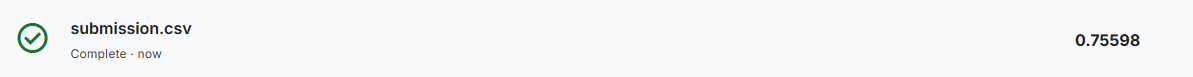

Prompt:

Create a Python script that installs required libraries and prepares a machine learning model for the Titanic competition on Kaggle. The script should:

1.Install the pycaret and kaggle packages.

2.Upload the Kaggle API key (kaggle.json) using Google Colab.

3.Create the necessary folder for the Kaggle API key and move the file.

4.Download the Titanic dataset from Kaggle using the kaggle CLI tool.

5.Extract the downloaded dataset.

6.Preprocess the Titanic dataset by:
Filling missing values in the Age column and categorizing it into groups like 'Baby', 'Teenager', etc.
Simplifying the Cabin column to retain only the first letter.
Filling missing values in the Fare column and categorizing it into quartiles.
Extracting the Lname and NamePrefix from the Name column.
Dropping unnecessary columns like Ticket, Name, and Embarked.

7.Split the data into training and testing datasets.

8.Set up a classification model environment using PyCaret, specifying the target variable and categorical features.

9.Compare multiple models and select the best performing one.

10.Create a Logistic Regression model and save it.

11.Create several other models (KNN, QDA, Naive Bayes,
Logistic Regression) and perform stacking using XGBoost.

12.Save the stacked model.

13.Perform hyperparameter tuning on the Logistic Regression and KNN models and save them.

14.Load the saved stacked model, make predictions on the test data, and calculate the accuracy.

15.Prepare a submission file with predictions for the Kaggle competition, save it as submission.csv, and provide a download link.

1. 安裝套件與設定 Kaggle API

In [ ]:
# 安裝 pycaret
!pip install pycaret
# 安裝 kaggle 套件
!pip install kaggle

# 上傳 kaggle.json
from google.colab import files
files.upload()  # 上傳 kaggle.json

# 創建 kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle (1).json


2. 下載與解壓 Titanic 資料集

In [ ]:
# 下載 Titanic 資料集
!kaggle competitions download -c titanic

# 解壓縮下載的檔案
!unzip titanic.zip

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


3. 讀取資料與預處理函數定義

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 讀取資料
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

# 顯示前幾筆資料
data_train.head()

# 資料預處理函數
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df


4. 處理資料與資料切分

In [ ]:
# 處理資料
data_train = transform_features(data_train)
data_test = transform_features(data_test)

# 顯示處理後的資料
data_train.head()

# 切分資料，80%作為訓練集，20%作為測試集
train_data, test_data = train_test_split(data_train.drop(['PassengerId'], axis=1), random_state=100, train_size=0.8)

train_data.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
408,0,3,male,Student,0,0,1_quartile,N,"Birkeland,",Mr.
480,0,3,male,Child,5,2,4_quartile,N,"Goodwin,",Master.
510,1,3,male,Young Adult,0,0,1_quartile,N,"Daly,",Mr.
609,1,1,female,Adult,0,0,4_quartile,C,"Shutes,",Miss.
547,1,2,male,Unknown,0,0,2_quartile,N,Padro,y


5. 設定 PyCaret 環境與模型訓練

In [ ]:
from pycaret.classification import *

# 設定訓練環境，設定目標變數和類別特徵
clf1 = setup(data=train_data,
             target='Survived',
             categorical_features=['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Lname', 'NamePrefix'],
             session_id=100)  # 固定隨機種子，使用 session_id 來控制隨機性

# 比較不同模型的表現
best_model = compare_models(fold=5)

# 創建一個 Logistic Regression 模型
log_reg = create_model('lr', fold=5)

# 儲存模型
save_model(log_reg, 'log_reg_model')

# 創建多個基礎模型
models = [
    create_model('knn', fold=5),
    create_model('qda', fold=5),
    create_model('nb', fold=5),
    create_model('lr', fold=5),
]

# 使用 XGBoost 進行第二層的 stacking
stacker = stack_models(estimator_list=models, meta_model=create_model('xgboost', fold=5))

# 儲存 stacking 模型
save_model(stacker, 'stacker_model')


,Description,Value
0,Session id,100
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(712, 10)"
4,Transformed data shape,"(712, 54)"
5,Transformed train set shape,"(498, 54)"
6,Transformed test set shape,"(214, 54)"
7,Numeric features,2
8,Categorical features,7
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8253,0.8816,0.7387,0.7872,0.7571,0.6218,0.6273,0.2400
et,Extra Trees Classifier,0.8153,0.8719,0.6640,0.8154,0.7265,0.5906,0.6019,0.2620
knn,K Neighbors Classifier,0.8094,0.8590,0.6484,0.8083,0.7144,0.5756,0.5870,0.2680
ridge,Ridge Classifier,0.8073,0.8785,0.6580,0.7975,0.7175,0.5740,0.5828,0.2480
rf,Random Forest Classifier,0.8052,0.8757,0.6310,0.8075,0.7060,0.5645,0.5756,0.7280
gbc,Gradient Boosting Classifier,0.7750,0.7828,0.6196,0.7301,0.6510,0.4955,0.5062,0.4920
xgboost,Extreme Gradient Boosting,0.7670,0.8219,0.5663,0.7500,0.6406,0.4754,0.4876,0.1920
ada,Ada Boost Classifier,0.7409,0.8007,0.5243,0.7207,0.5845,0.4113,0.4342,0.4020
dt,Decision Tree Classifier,0.6947,0.6640,0.5404,0.6167,0.5713,0.3374,0.3413,0.2300
lda,Linear Discriminant Analysis,0.6828,0.7792,0.2461,0.7337,0.3662,0.2201,0.2791,0.1840


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8400,0.9140,0.8378,0.7561,0.7949,0.6643,0.6666
1,0.8000,0.8525,0.6053,0.8214,0.6970,0.5528,0.5671
2,0.8200,0.8731,0.7368,0.7778,0.7568,0.6141,0.6146
3,0.8586,0.9180,0.8649,0.7805,0.8205,0.7044,0.7069
4,0.8081,0.8505,0.6486,0.8000,0.7164,0.5738,0.5810
Mean,0.8253,0.8816,0.7387,0.7872,0.7571,0.6218,0.6273
Std,0.0214,0.0292,0.1017,0.0221,0.0463,0.0561,0.0526


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8200,0.8885,0.7568,0.7568,0.7568,0.6139,0.6139
1,0.7800,0.8610,0.5526,0.8077,0.6562,0.5027,0.5223
2,0.7600,0.8591,0.5000,0.7917,0.6129,0.4516,0.4766
3,0.8485,0.8731,0.7568,0.8235,0.7887,0.6710,0.6724
4,0.8384,0.8134,0.6757,0.8621,0.7576,0.6390,0.6497
Mean,0.8094,0.8590,0.6484,0.8083,0.7144,0.5756,0.5870
Std,0.0340,0.0251,0.1053,0.0348,0.0676,0.0840,0.0753


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4700,0.6141,0.7568,0.3889,0.5138,0.0488,0.0627
1,0.4200,0.4068,0.1842,0.2059,0.1944,-0.2565,-0.2575
2,0.4300,0.7729,0.9737,0.3978,0.5649,0.0550,0.1340
3,0.4242,0.7895,1.0000,0.3936,0.5649,0.0615,0.1782
4,0.5152,0.7609,1.0000,0.4353,0.6066,0.1790,0.3135
Mean,0.4519,0.6688,0.7829,0.3643,0.4889,0.0176,0.0862
Std,0.0363,0.1453,0.3130,0.0809,0.1501,0.1452,0.1903


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3900,0.5798,0.9730,0.3750,0.5414,0.0155,0.0507
1,0.4000,0.5507,0.8947,0.3778,0.5312,-0.0067,-0.0137
2,0.4300,0.7714,1.0000,0.4000,0.5714,0.0625,0.1796
3,0.3939,0.7315,1.0000,0.3814,0.5522,0.0243,0.1109
4,0.5152,0.7860,0.9730,0.4337,0.6000,0.1718,0.2825
Mean,0.4258,0.6839,0.9681,0.3936,0.5593,0.0535,0.1220
Std,0.0468,0.0989,0.0386,0.0219,0.0243,0.0633,0.1027


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8400,0.9140,0.8378,0.7561,0.7949,0.6643,0.6666
1,0.8000,0.8525,0.6053,0.8214,0.6970,0.5528,0.5671
2,0.8200,0.8731,0.7368,0.7778,0.7568,0.6141,0.6146
3,0.8586,0.9180,0.8649,0.7805,0.8205,0.7044,0.7069
4,0.8081,0.8505,0.6486,0.8000,0.7164,0.5738,0.5810
Mean,0.8253,0.8816,0.7387,0.7872,0.7571,0.6218,0.6273
Std,0.0214,0.0292,0.1017,0.0221,0.0463,0.0561,0.0526


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7400,0.8254,0.5946,0.6667,0.6286,0.4296,0.4312
1,0.8200,0.8519,0.6316,0.8571,0.7273,0.5975,0.6130
2,0.7700,0.8283,0.6053,0.7419,0.6667,0.4938,0.4998
3,0.8081,0.8751,0.6486,0.8000,0.7164,0.5738,0.5810
4,0.6970,0.7286,0.3514,0.6842,0.4643,0.2823,0.3127
Mean,0.7670,0.8219,0.5663,0.7500,0.6406,0.4754,0.4876
Std,0.0450,0.0500,0.1091,0.0712,0.0950,0.1134,0.1080


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7400,0.8125,0.6667,0.6316,0.6486,0.4425,0.4429
1,0.8800,0.9372,0.8421,0.8421,0.8421,0.7453,0.7453
2,0.8600,0.9482,0.6842,0.9286,0.7879,0.6869,0.7048
3,0.7800,0.8073,0.5789,0.7857,0.6667,0.5081,0.5212
4,0.7600,0.8769,0.5789,0.7333,0.6471,0.4690,0.4766
5,0.7200,0.7801,0.5789,0.6471,0.6111,0.3934,0.3949
6,0.8200,0.8277,0.6842,0.8125,0.7429,0.6060,0.6113
7,0.7600,0.8676,0.6316,0.7059,0.6667,0.4801,0.4819
8,0.7959,0.7366,0.5556,0.8333,0.6667,0.5279,0.5505


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['SibSp', 'Parch'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Pclass', 'Sex', 'Age', 'Fare...
                                                                   learning_rate=None,
                                                                   max_bin=None,
         

6. 模型預測與結果處理

In [ ]:
# 超參數優化
# 進行超參數優化的步驟
tuned_log_reg = tune_model(log_reg)  # 調整 Logistic Regression 模型的超參數
tuned_knn = tune_model(models[0])  # 調整 KNN 模型的超參數

# 儲存已調整的模型
save_model(tuned_log_reg, 'tuned_log_reg_model')
save_model(tuned_knn, 'tuned_knn_model')

# 載入儲存的模型
loaded_model = load_model('stacker_model')

# 預測測試集
predictions = predict_model(loaded_model, data=test_data)

# 顯示預測結果
predictions.head()

# 計算準確度
from sklearn.metrics import accuracy_score
# 使用 'prediction_label' 來計算準確率
accuracy = accuracy_score(predictions['Survived'], predictions['prediction_label'])
print(f'Accuracy: {accuracy:.4f}')

# 使用模型進行預測
test_predictions = predict_model(loaded_model, data=data_test)

# 取得預測結果
submission = test_predictions[['PassengerId', 'prediction_label']]
submission.columns = ['PassengerId', 'Survived']

# 查看結果
submission.head()

# 儲存為 CSV 文件以便上傳至 Kaggle
submission.to_csv('submission.csv', index=False)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7800,0.8819,0.8889,0.6400,0.7442,0.5600,0.5833
1,0.8800,0.9448,1.0000,0.7600,0.8636,0.7600,0.7829
2,0.8800,0.9032,0.7368,0.9333,0.8235,0.7345,0.7463
3,0.7600,0.8031,0.5789,0.7333,0.6471,0.4690,0.4766
4,0.8200,0.8396,0.7895,0.7500,0.7692,0.6218,0.6224
5,0.8600,0.8998,0.8947,0.7727,0.8293,0.7117,0.7172
6,0.7800,0.8438,0.7895,0.6818,0.7317,0.5470,0.5512
7,0.9000,0.9771,0.8947,0.8500,0.8718,0.7899,0.7906
8,0.7959,0.8047,0.5556,0.8333,0.6667,0.5279,0.5505


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7800,0.8255,0.7222,0.6842,0.7027,0.5283,0.5288
1,0.9000,0.9542,0.8421,0.8889,0.8649,0.7856,0.7863
2,0.8600,0.8998,0.7895,0.8333,0.8108,0.6998,0.7005
3,0.7800,0.7971,0.4211,1.0000,0.5926,0.4742,0.5575
4,0.7200,0.8540,0.4211,0.7273,0.5333,0.3530,0.3800
5,0.7600,0.8311,0.5789,0.7333,0.6471,0.4690,0.4766
6,0.8400,0.8234,0.7895,0.7895,0.7895,0.6604,0.6604
7,0.8200,0.9261,0.5263,1.0000,0.6897,0.5794,0.6387
8,0.8163,0.7303,0.5556,0.9091,0.6897,0.5698,0.6046


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8380,0.8660,0.6933,0.8966,0.7820,0.6564,0.6701


Accuracy: 0.8380


7. 下載結果檔案

In [ ]:
from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 結果

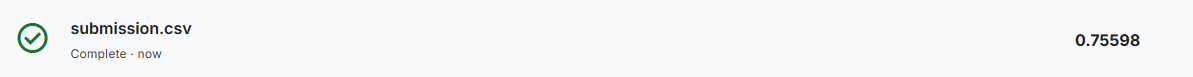